In [1]:
import pandas as pd
import time
import datetime
import numpy as np

In [ ]:
df_large = pd.read_csv('./ukb22601.csv')
df_assessment_center = pd.read_csv('./ukb_assessment_center_data.csv')
df_sex_data = pd.read_csv('./ukb_sex_data.csv')

In [ ]:
df_interim = pd.merge(df_assessment_center, df_sex_data, how='inner', on=['eid'])
df_concated = pd.merge(df_large, df_interim, how='inner', on=['eid'])

In [ ]:
# Irregularity in csv file: VVI

'''
1. Diabetes status for 1002256 volume is 1, where as non_cancer_disease(20002-*.*) does not hold any coding that is
assigned for various kind of diabetes i.e. 1246, 1247, 1248, 1584 !!!

2.
'''

In [ ]:
to_include_later = {'20002-2.*':'non_cancer_disease', '20003-2.*': 'treatment_medications',  '22414-2.*': 'image_quality'}
acquired_columns = {'eid':'volume_id', '34-0.0': 'birth_year', '52-0.0':'birth_month', '53-2.0':'assesment_year',
                    '31-0.0': 'sex', '54-2.0': 'assesment_center_id', '1558-2.0': 'alcohol_intake_freq', 
                   '2443-2.0':'diabetes_status', '6177-2.0': 'med_1', '6177-2.1': 'med_2', '6177-2.2': 'med_3',
                   '20116-2.0': 'smoking_status', '21001-2.0': 'bmi'}

data_encoding_ids = {'birth_month':'8',
                    'sex':'9', 'alcohol_intake_freq':'100402', 
                    'diabetes_status':'100349', 'med_1': '100625', 'med_2': '100625', 
                    'med_3': '100625', ' ,  ': '90'}



In [ ]:
def transform_to_categorical(df, categorical_features_list):
    for f in categorical_features_list:
        dfDummies = pd.get_dummies(df[f], prefix = f)
        df = pd.concat([df, dfDummies], axis=1)
    return df

In [ ]:
df_concated_ = df_concated.rename(columns={'22414-2.0': 'quality_0', '22414-2.1': 'quality_1'})
df_concated__ = transform_to_categorical(df_concated_, ['quality_0', 'quality_1'])
df_quality = df_concated__.drop(columns=['quality_0', 'quality_1']).filter(regex=('quality_*'))
old_cols = df_quality.columns
for q_c in range(1,10):
    q_0_col = f'quality_0_{q_c}.0'
    q_1_col = f'quality_1_{q_c}.0'
    if q_0_col in df_quality.columns and q_1_col in df_quality.columns:
        print(f'quality_{q_c}', q_0_col, q_1_col)
        df_quality[f'quality_{q_c}'] = df_quality[q_0_col] + df_quality[q_1_col]
    elif q_0_col in df_quality.columns:
        print('q_0_only', q_0_col)
        df_quality[f'quality_{q_c}'] = df_quality[q_0_col]
    elif q_1_col in df_quality.columns:
        print('q_1_only', q_1_col)
        df_quality[f'quality_{q_c}'] = df_quality[q_1_col]
    else:
        print('nothing but 0', q_c)
        df_quality[f'quality_{q_c}'] = 0
df_concated__ = df_concated__.drop(columns=old_cols)
df_concated__ = df_concated__.drop(columns=['quality_0', 'quality_1'])
df_quality = df_quality.drop(columns=old_cols)
df_concated__[[f'quality_{i}' for i in range(1, 10)]] = df_quality

In [ ]:
# Diabetes 
# 1246: Gestational Diabetes, 1247: Diabetes 1, 1248: diabetes 2, 1584:diabetes_insipidus

In [ ]:
# df_concated_styler = df_concated__.style.applymap(lambda x: 'background-color : yellow' if x in [1246, 1247, 1248, 1584] else '')
# df_concated_styler

In [ ]:
df_diabetes = df_concated__.filter(regex=('20002-2.*')).fillna(-100).applymap(lambda x: x if int(x) in [1246, 1247, 1248, 1584] else None)

In [ ]:
# df_diabetes = df_diabetes.fillna('')


In [ ]:
# df_diabetes.to_csv('x.csv')

In [ ]:
df_diabetes_ = transform_to_categorical(df_diabetes, [f'20002-2.{i}' for i in range(29)])

In [ ]:
df_diabetes_ = df_diabetes_.drop(columns=[f'20002-2.{i}' for i in range(29)])

In [ ]:
df_did = df_diabetes_.copy()
for d_id in [1246, 1247, 1248, 1584]:
    df_d = df_did.filter(regex=(f'20002-2.*_{d_id}.0'))
    old_cols = df_d.columns
    df_did[f'diabetes_{d_id}'] = df_d.sum(axis=1)
    df_did = df_did.drop(columns=old_cols)

# df_did.drop(columns=[])


In [ ]:
df_did

In [ ]:
# Image Quality Values 
# 1	Severe Motion Artefact
# 2	Tall Subject
# 3	Broken Coil Element
# 4	Complicated Swap
# 5	Complicated Swap in ASAT
# 6	Corrupt Data
# 7	Extreme Dogbites
# 8	Metal
# 9	Minor Metal Artefact in ASAT

In [ ]:
df_concated__ = df_concated__.drop(columns=[f'20002-2.{i}' for i in range(29)])
df_concated__[[f'diabetes_{i}' for i in [1246, 1247, 1248, 1584]]] = df_did

In [ ]:
df_other_feats = df_concated__[[f'diabetes_{i}' for i in [1246, 1247, 1248, 1584]] + [f'quality_{i}' for i in range(1, 10)]]

In [ ]:
cols_map = {
    'diabetes_1246': 'diabetes_gestational', 'diabetes_1247': 'diabetes_typeI', 'diabetes_1248': 'diabetes_typeII',
    'diabetes_1584':'diabetes_insipidus', 'quality_1':'q_motion_artifact','quality_2':'q_tall_sub',
    'quality_3':'q_broken_coil','quality_4':'q_complicated_swap','quality_5':'q_complicated_swap_ASAT',
    'quality_6':'q_corrupt_data', 'quality_7':'q_dogbites','quality_8':'q_metal_artifact',
    'quality_9':'q_minor_metal_artifact',
}
df_other_feats = df_other_feats.rename(columns=cols_map)

In [ ]:
df_other_feats

In [ ]:
df_imp = df_concated[list(acquired_columns.keys())]

In [ ]:
df = df_imp.rename(columns=acquired_columns)

In [ ]:
df_ = transform_to_categorical(df, ['med_1', 'med_2', 'med_3'])
df__ = df_.drop(columns=['med_1', 'med_2', 'med_3']).filter(regex=('med_*'))


In [ ]:
df_did = df__.copy()
for d_id in [1,2,3,-7,-1,-3]:
    df_d = pd.concat([df_did.filter(regex=(f'med_{i}_{d_id}.0')) for i in range(1,4)], axis=1)
    old_cols = df_d.columns.values
    df_did[f'med_{d_id}'] = df_d.sum(axis=1)
    df_did = df_did.drop(columns=old_cols)


In [ ]:
# Medication codings 
# 1	Cholesterol lowering medication
# 2	Blood pressure medication
# 3	Insulin
# -7	None of the above
# -1	Do not know
# -3	Prefer not to answe

In [ ]:
med_col_map = {'med_1':'med_cholesterol_lowering','med_2':'med_blood_pressure','med_3':'med_insulin',
               'med_-7':'med_none_above','med_-1':'med_do_not_know','med_-3':'med_prefer_no_ans'}
df_did = df_did.rename(columns=med_col_map)
df_did

In [ ]:
from datetime import datetime
df['day'] = 1
df['dob'] = df.apply(lambda row: datetime(row['birth_year'], row['birth_month'], row['day'] ), axis=1)
t1 = pd.to_datetime(df['dob'])
t2 = pd.to_datetime(df['assesment_year'])
df['age'] = (t2-t1).astype('timedelta64[Y]').astype('int')
df = df.drop(columns = ['day', 'dob', 'birth_month', 'birth_year', 'assesment_year'])


In [ ]:
other_feats_col = df_other_feats.columns.values
md_feats = df_did.columns.values
df = pd.concat([df, df_other_feats, df_did], axis=1)

In [ ]:
# Removed other diabetes_state other than normal or diabetic
df = df[df['diabetes_status'].isin([0.0, 1.0])]
# Removed prefer not to say
df = df[df['alcohol_intake_freq'] != '-3.0']
df

In [ ]:
df = df[['volume_id', 'age', 'sex', 'bmi', 'diabetes_status']+list(other_feats_col)+list(md_feats)]
df = df.rename(columns={'bmi': 'bmi_numeric'})


In [ ]:
df = df.dropna()
df['volume_id'] = df['volume_id'].apply(lambda x: str(x)+'_20201_2_0')
df

In [ ]:
df.to_csv('./ukb_diabetes_basic_feats.csv', index='volume_id')

In [ ]:
#  UKB VOLUME PROCESSED FILE CONCATENATIONS

In [2]:
def organise_target_and_volumeid(df_path='/home/abhijit/Jyotirmay/my_thesis/projects/MC_dropout_quicknat/reports/MC_dropout_quicknat_UKB_v2/UKB/10_1573078374.453554_report.csv'):
    df = pd.read_csv(df_path)
    if df['dataset'].values[1] != 2:
        print('Not a UKB dataset report, not processing!')
        return False
    def replace_func(value):
        string = value[-1]
        return f'Dixon_BH_17s_opp_Dixon_BH_17{string}.nii.gz' if string == 's' else f'Dixon_BH_17s_opp_Dixon_BH_17s{string}.nii.gz'
    df['target_scan_file'] = df['volume_id'].apply(replace_func)
    df['volume_id'] = df['volume_id'].apply(lambda x: x[:-1])
    return df

In [3]:
def concat_partial_model_reports(paths):
    df = None
#     ids = ['10_1573078374.453554', '10_1573225388.879571', '10_1573391294.0298784']
#     paths = [f'/home/abhijit/Jyotirmay/my_thesis/projects/MC_dropout_quicknat/reports/MC_dropout_quicknat_UKB_v2/UKB/{i}_report.csv' for i in ids]
    
    for ix, p in enumerate(paths):
        df_ = organise_target_and_volumeid(p)
        df_ = df_.drop(df_.index[0])
        if ix == 0:
            df = df_
        else:
            df = df.append(df_, ignore_index=True)
    return df
        
ids = ['10_1573078374.453554', '10_1573225388.879571', '10_1573391294.0298784']
paths = [f'/home/abhijit/Jyotirmay/my_thesis/projects/MC_dropout_quicknat/reports/MC_dropout_quicknat_UKB_v2/UKB/{i}_report.csv' for i in ids]

df = concat_partial_model_reports(paths)
        

In [4]:
df[df.dataset==0]

,project,dataset,model_name,volume_id,samples,sncc,ged,iou_spleen,iou_liver,iou_mean,...,surface_distance_prtogt_spleen,surface_distance_prtogt_liver,surface_distance_prtogt_mean,surface_distance_gttopr_spleen,surface_distance_gttopr_liver,surface_distance_gttopr_mean,surface_distance_avg_spleen,surface_distance_avg_liver,surface_distance_avg_mean,target_scan_file


In [5]:
# df.to_csv(f'/home/abhijit/Jyotirmay/my_thesis/projects/MC_dropout_quicknat/reports/MC_dropout_quicknat_UKB_v2/UKB/10_0.0_report.csv')

In [6]:
df = pd.read_csv('/home/abhijit/Jyotirmay/my_thesis/projects/MC_dropout_quicknat/reports/MC_dropout_quicknat_UKB_v2/UKB/10_0.0_report.csv', index_col=0)




In [7]:
df

,project,dataset,model_name,volume_id,samples,sncc,ged,iou_spleen,iou_liver,iou_mean,...,surface_distance_prtogt_spleen,surface_distance_prtogt_liver,surface_distance_prtogt_mean,surface_distance_gttopr_spleen,surface_distance_gttopr_liver,surface_distance_gttopr_mean,surface_distance_avg_spleen,surface_distance_avg_liver,surface_distance_avg_mean,target_scan_file
0,2,2,MC_dropout_quicknat_UKB_v2,1000410_20201_2_0,10,NaN,NaN,0.545999,0.859389,0.702694,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Dixon_BH_17s_opp_Dixon_BH_17sb.nii.gz
1,2,2,MC_dropout_quicknat_UKB_v2,1000698_20201_2_0,10,NaN,NaN,0.564894,0.766553,0.665723,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Dixon_BH_17s_opp_Dixon_BH_17sb.nii.gz
2,2,2,MC_dropout_quicknat_UKB_v2,1000857_20201_2_0,10,NaN,NaN,0.719200,0.851086,0.785143,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Dixon_BH_17s_opp_Dixon_BH_17sb.nii.gz
3,2,2,MC_dropout_quicknat_UKB_v2,1000870_20201_2_0,10,NaN,NaN,0.738249,0.585848,0.662049,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Dixon_BH_17s_opp_Dixon_BH_17s.nii.gz
4,2,2,MC_dropout_quicknat_UKB_v2,1000870_20201_2_0,10,NaN,NaN,0.335961,0.356094,0.346028,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Dixon_BH_17s_opp_Dixon_BH_17sa.nii.gz
5,2,2,MC_dropout_quicknat_UKB_v2,1002272_20201_2_0,10,NaN,NaN,0.436899,0.369021,0.402960,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Dixon_BH_17s_opp_Dixon_BH_17s.nii.gz
6,2,2,MC_dropout_quicknat_UKB_v2,1002272_20201_2_0,10,NaN,NaN,0.875844,0.705661,0.790752,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Dixon_BH_17s_opp_Dixon_BH_17sa.nii.gz
7,2,2,MC_dropout_quicknat_UKB_v2,1002359_20201_2_0,10,NaN,NaN,0.849520,0.884133,0.866826,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Dixon_BH_17s_opp_Dixon_BH_17sb.nii.gz
8,2,2,MC_dropout_quicknat_UKB_v2,1002876_20201_2_0,10,NaN,NaN,0.776984,0.819199,0.798091,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Dixon_BH_17s_opp_Dixon_BH_17sb.nii.gz
9,2,2,MC_dropout_quicknat_UKB_v2,1003082_20201_2_0,10,NaN,NaN,0.418048,0.798031,0.608040,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Dixon_BH_17s_opp_Dixon_BH_17sa.nii.gz


In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# df[['iou_liver', 'iou_spleen']].boxplot(rot=45)
# plt.show()

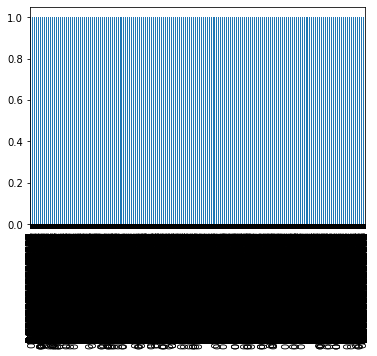

In [9]:
# df.plot.bar(x='iou_mean')
pd.value_counts(df.iou_mean).plot.bar()
plt.show()